# Baseline Model: Random Forest on Real Data

## Overview

This notebook establishes a baseline model using a Random Forest regressor trained exclusively on real aircraft data. This serves as our performance benchmark against which we'll compare the augmented model trained with synthetic data.

## Objectives

1. Load processed data
2. Train a Random Forest baseline model
3. Evaluate performance with multiple metrics
4. Visualize feature importance and predictions
5. Save the baseline model

## Setup

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Import src modules
from src.training import train_baseline_model
from src.evaluation import calculate_regression_metrics

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)

print('✓ Libraries and modules imported successfully!')

✓ Libraries and modules imported successfully!


## 1. Load Data

In [2]:
# Load processed data from data preparation notebook
train_data = pd.read_csv('../data/processed/train_data.csv')
test_data = pd.read_csv('../data/processed/test_data.csv')

# Separate features and target
X_train = train_data.drop('co2_kg', axis=1)
y_train = train_data['co2_kg']

X_test = test_data.drop('co2_kg', axis=1)
y_test = test_data['co2_kg']

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')
print(f'\nTarget statistics (test set):')
print(y_test.describe())

Training set: (3500, 25)
Test set: (750, 25)

Target statistics (test set):
count     750.000000
mean      103.069873
std       176.699946
min        10.000000
25%        26.448893
50%        45.158417
75%       111.343620
max      2069.665983
Name: co2_kg, dtype: float64


## 2. Train Baseline Model

In [3]:
# Train Random Forest using src.training.train_baseline_model()
# Uses consistent hyperparameters across all notebooks
print('Training baseline Random Forest model...')
rf_baseline = train_baseline_model(
    X_train, y_train,
    model_type='rf',
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    verbose=True
)
print('Baseline model trained!')

Training baseline Random Forest model...
Training Random Forest with 100 trees...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s


✓ Training complete!
Baseline model trained!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


## 3. Model Evaluation

In [4]:
# Make predictions and calculate metrics using src.evaluation
y_train_pred = rf_baseline.predict(X_train)
y_test_pred = rf_baseline.predict(X_test)

# Calculate comprehensive metrics
train_metrics = calculate_regression_metrics(y_train.values, y_train_pred)
test_metrics = calculate_regression_metrics(y_test.values, y_test_pred)

# Display results
print('\n' + '='*60)
print('BASELINE MODEL PERFORMANCE')
print('='*60)
print(f'\nTraining Set Metrics:')
for metric, value in train_metrics.items():
    print(f'  {metric}: {value:.4f}')

print(f'\nTest Set Metrics:')
for metric, value in test_metrics.items():
    print(f'  {metric}: {value:.4f}')
print('='*60)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s



BASELINE MODEL PERFORMANCE

Training Set Metrics:
  RMSE: 12.6878
  MAE: 4.8832
  R2: 0.9938
  MAPE: 4.5321

Test Set Metrics:
  RMSE: 33.2725
  MAE: 10.5415
  R2: 0.9645
  MAPE: 9.7022


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


## 4. Feature Importance

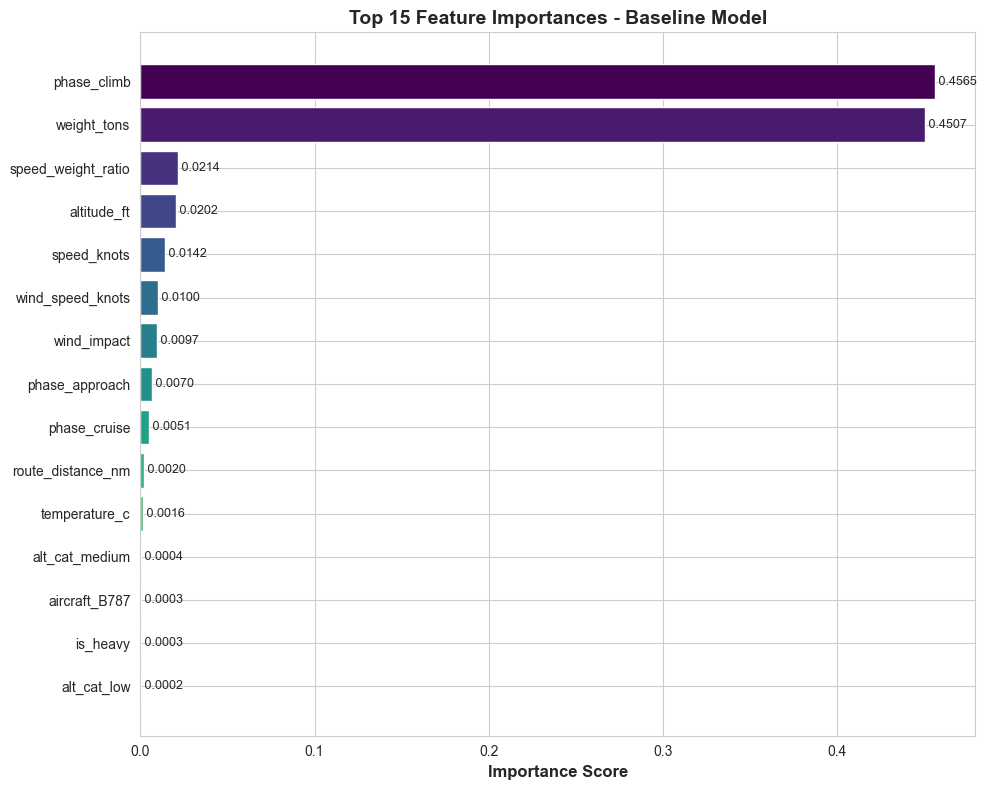


Top 5 Most Important Features:
           feature  importance
       phase_climb    0.456476
       weight_tons    0.450702
speed_weight_ratio    0.021371
       altitude_ft    0.020228
       speed_knots    0.014211


In [7]:
# Extract and visualize feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = ax.barh(range(len(top_features)), top_features['importance'].values, color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importances - Baseline Model', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'], i, f" {row['importance']:.4f}", va='center', fontsize=9)

plt.tight_layout()
#plt.savefig('../plots/baseline_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nTop 5 Most Important Features:')
print(feature_importance.head(5).to_string(index=False))

## 5. Predictions vs Actuals

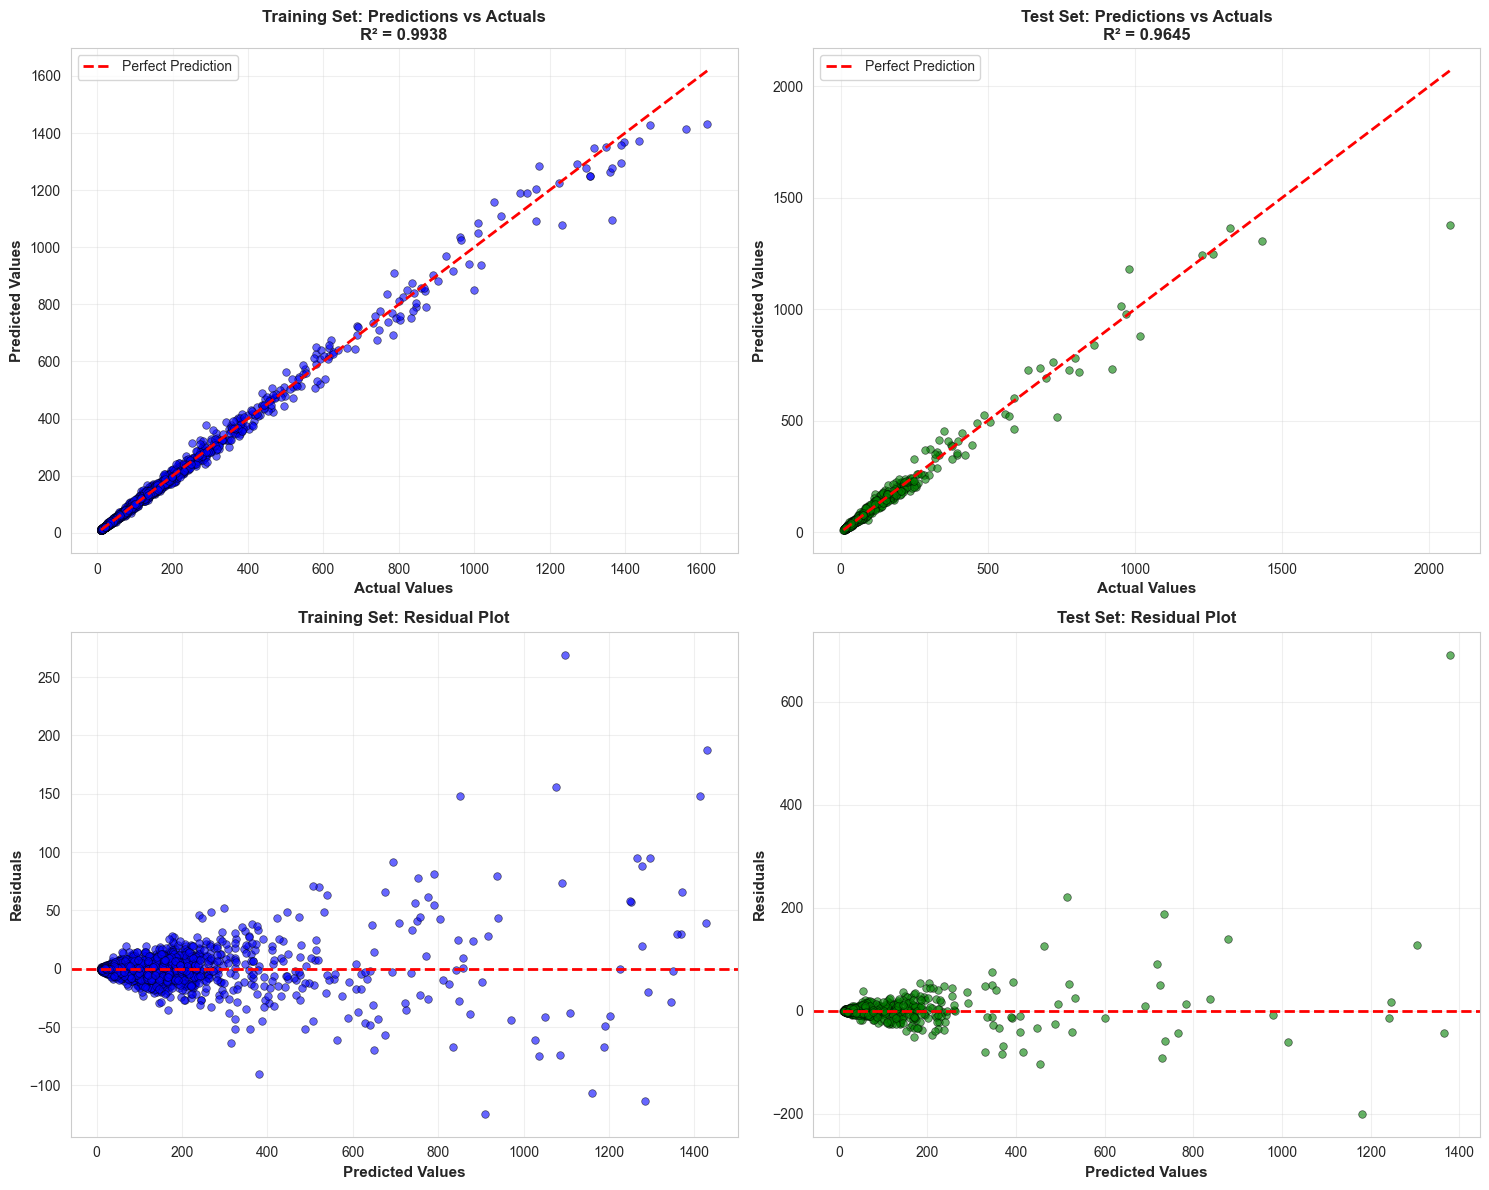

In [9]:
# Comprehensive predictions vs actuals visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Train set predictions
ax1 = axes[0, 0]
ax1.scatter(y_train, y_train_pred, alpha=0.6, s=30, color='blue', edgecolors='black', linewidth=0.5)
min_val, max_val = min(y_train.min(), y_train_pred.min()), max(y_train.max(), y_train_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Values', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted Values', fontsize=11, fontweight='bold')
ax1.set_title(f'Training Set: Predictions vs Actuals\nR² = {train_metrics["R2"]:.4f}', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test set predictions
ax2 = axes[0, 1]
ax2.scatter(y_test, y_test_pred, alpha=0.6, s=30, color='green', edgecolors='black', linewidth=0.5)
min_val, max_val = min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Values', fontsize=11, fontweight='bold')
ax2.set_ylabel('Predicted Values', fontsize=11, fontweight='bold')
ax2.set_title(f'Test Set: Predictions vs Actuals\nR² = {test_metrics["R2"]:.4f}', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Residuals - Training
train_residuals = y_train.values - y_train_pred
ax3 = axes[1, 0]
ax3.scatter(y_train_pred, train_residuals, alpha=0.6, s=30, color='blue', edgecolors='black', linewidth=0.5)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Values', fontsize=11, fontweight='bold')
ax3.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax3.set_title('Training Set: Residual Plot', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Residuals - Testing
test_residuals = y_test.values - y_test_pred
ax4 = axes[1, 1]
ax4.scatter(y_test_pred, test_residuals, alpha=0.6, s=30, color='green', edgecolors='black', linewidth=0.5)
ax4.axhline(y=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Values', fontsize=11, fontweight='bold')
ax4.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax4.set_title('Test Set: Residual Plot', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('../plots/baseline_predictions_vs_actuals.png', dpi=300, bbox_inches='tight')
plt.show()

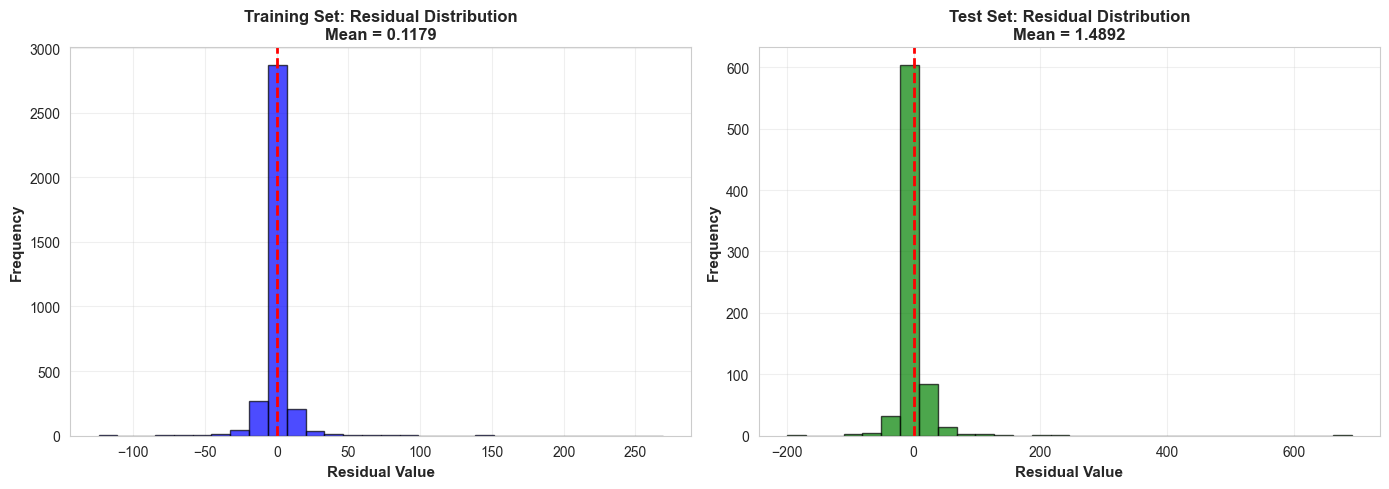

In [11]:
# Residual distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Residual Value', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title(f'Training Set: Residual Distribution\nMean = {train_residuals.mean():.4f}', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].hist(test_residuals, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residual Value', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title(f'Test Set: Residual Distribution\nMean = {test_residuals.mean():.4f}', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('../plots/baseline_residual_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Save Model & Metrics

In [12]:
# Create models directory
os.makedirs('../models', exist_ok=True)
os.makedirs('../plots', exist_ok=True)

# Save baseline model
model_path = '../models/baseline_rf.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_baseline, f)

# Save baseline metrics
metrics = {
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'feature_importances': feature_importance
}

metrics_path = '../models/baseline_metrics.pkl'
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics, f)

print(f'✓ Baseline model saved to: {model_path}')
print(f'✓ Baseline metrics saved to: {metrics_path}')

✓ Baseline model saved to: ../models/baseline_rf.pkl
✓ Baseline metrics saved to: ../models/baseline_metrics.pkl


## 7. Summary

In [14]:
print('\n' + '='*70)
print('BASELINE MODEL SUMMARY')
print('='*70)
print(f'\nDataset:')
print(f'  Training samples: {len(X_train):,}')
print(f'  Test samples: {len(X_test):,}')
print(f'  Features: {X_train.shape[1]}')

print(f'\nModel Configuration:')
print(f'  Algorithm: Random Forest')
print(f'  Trees: 100')
print(f'  Max depth: 20')

print(f'\nTest Set Performance:')
print(f'  RMSE: {test_metrics["RMSE"]:.4f}')
print(f'  MAE: {test_metrics["MAE"]:.4f}')
print(f'  R²: {test_metrics["R2"]:.4f}')

print(f'\nTop 3 Features:')
for idx, row in feature_importance.head(3).iterrows():
    print(f'  {row["feature"]}: {row["importance"]:.4f}')

print(f'\nBaseline established. Next: Run 03_ctgan_training.ipynb')
print('='*70)


BASELINE MODEL SUMMARY

Dataset:
  Training samples: 3,500
  Test samples: 750
  Features: 25

Model Configuration:
  Algorithm: Random Forest
  Trees: 100
  Max depth: 20

Test Set Performance:
  RMSE: 33.2725
  MAE: 10.5415
  R²: 0.9645

Top 3 Features:
  phase_climb: 0.4565
  weight_tons: 0.4507
  speed_weight_ratio: 0.0214

Baseline established. Next: Run 03_ctgan_training.ipynb
